# EndTailImputer

The EndTailImputer() replaces missing data by a value at either tail of the distribution. It automatically determines the value to be used in the imputation using the mean plus or minus a factor of the standard deviation, or using the inter-quartile range proximity rule. Alternatively, it can use a factor of the maximum value.

It works only with numerical variables.

**For this demonstration, we use the Ames House Prices dataset produced by Professor Dean De Cock:**

Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3

http://jse.amstat.org/v19n3/decock.pdf

https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.imputation import EndTailImputer

In [2]:
data = pd.read_csv('houseprice.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((1022, 79), (438, 79))

In [4]:
# numerical variables with missing data

X_train[['LotFrontage', 'MasVnrArea']].isnull().mean()

LotFrontage    0.184932
MasVnrArea     0.004892
dtype: float64

### Gaussian, right tail

In [5]:
tail_imputer = EndTailImputer(
    imputation_method='gaussian', # uses the mean and standard deviation to determine the value
    tail='right', # it will find a value at the right tail of the distribution for the imputation
    fold=3, # it will multiply the std by 3
    variables=['LotFrontage', 'MasVnrArea'])

# finds the imputation values

tail_imputer.fit(X_train)

EndTailImputer(variables=['LotFrontage', 'MasVnrArea'])

In [6]:
tail_imputer.imputer_dict_

{'LotFrontage': 138.9022201686726, 'MasVnrArea': 648.3947111415165}

In [7]:
# transform the data
train_t = tail_imputer.transform(X_train)
test_t = tail_imputer.transform(X_test)

# and check we no longer have NA
train_t['LotFrontage'].isnull().sum()

0

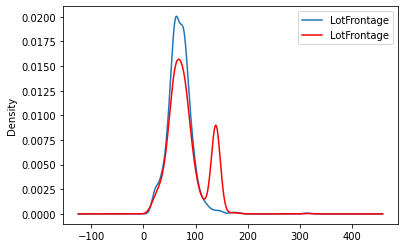

In [8]:
# we can see that the distribution has changed slightly with
# more values accumulating towards the right tail

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

### IQR distribution, left tail

In [9]:
tail_imputer = EndTailImputer(
    imputation_method='iqr', # uses the inter-quartile range proximity rule
    tail='left', # determines values at the left tail of the distribution
    fold=3, # multiplies the IQR by 3
    variables=['LotFrontage', 'MasVnrArea'])

# finds the imputation values
tail_imputer.fit(X_train)

EndTailImputer(imputation_method='iqr', tail='left',
               variables=['LotFrontage', 'MasVnrArea'])

In [10]:
# imputation values per variable

tail_imputer.imputer_dict_

{'LotFrontage': -8.0, 'MasVnrArea': -510.0}

In [11]:
# transform the data

train_t = tail_imputer.transform(X_train)
test_t = tail_imputer.transform(X_test)

train_t[['LotFrontage', 'MasVnrArea']].isnull().sum()

LotFrontage    0
MasVnrArea     0
dtype: int64

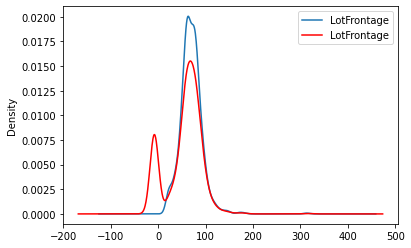

In [12]:
# we can see that the distribution has changed slightly with now more values
#  accumulating towards the  left tail

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

### Impute with the maximum value

In [13]:
tail_imputer = EndTailImputer(
    imputation_method='max',# imputes beyond the maximum value
    fold=3,# multiplies the maximum value by 3
    variables=['LotFrontage', 'MasVnrArea'])

# find imputation value
tail_imputer.fit(X_train)

EndTailImputer(imputation_method='max', variables=['LotFrontage', 'MasVnrArea'])

In [14]:
# imputation values
tail_imputer.imputer_dict_

{'LotFrontage': 939.0, 'MasVnrArea': 4800.0}

In [15]:
# the original maximum values,
# note how the imputer multiplied these by 3

X_train[tail_imputer.variables_].max()

LotFrontage     313.0
MasVnrArea     1600.0
dtype: float64

In [16]:
# transform the data
train_t = tail_imputer.transform(X_train)
test_t = tail_imputer.transform(X_test)

train_t[['LotFrontage', 'MasVnrArea']].isnull().sum()

LotFrontage    0
MasVnrArea     0
dtype: int64

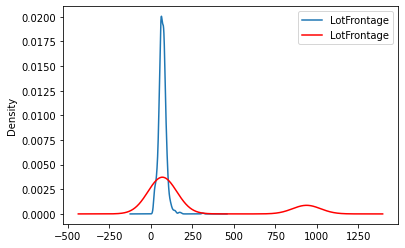

In [17]:
# we can see that the distribution has changed slightly with now more values
#  accumulating towards the  left tail

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')